<h1><center>Segment customers of an e-commerce: Maintenance</center></h1>

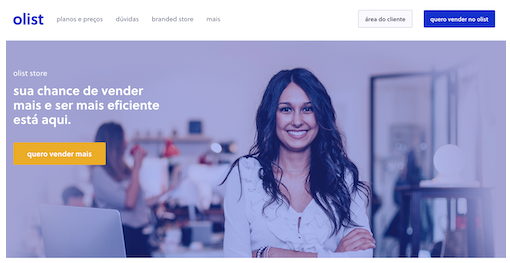

### TABLE OF CONTENTS
#### Project display
#### 1. Maintenance

### Project display

**Olist** wants to provide its e-commerce teams with **customer segmentation** that they can use on a daily basis for their communication campaigns.

The goal is to understand the different types of users through their behavior and personal data.

The goal is to provide the marketing team with an actionable description of a segmentation and its underlying logic for optimal use, as well as a maintenance contract proposal based on an analysis of segment stability over the course of the time.

In [1]:
from olist_eda_functions import *
from olist_modeling_functions import *

%pylab inline
%matplotlib inline
pd.set_option('display.max_columns',200)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# For full display of DataFrames.
pd.set_option("expand_frame_repr", True)

####  Get the Data

In [3]:
# Load pickle from disk
df_rfm = pd.read_pickle('pickle_df_rfm.pkl')
df = pd.read_pickle('pickle_df.pkl')
#df = pd.read_pickle('pickle-file.pkl.gz', compression='gzip')

In [4]:
df_rfm.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
0000f46a3911fa3c0805444483337064,536,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62
0004aac84e0df4da2b147fca70cf8255,287,1,196.89


In [5]:
# check if the data types are well preserved
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91151 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    91151 non-null  int64  
 1   Frequency  91151 non-null  int64  
 2   Monetary   91151 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.8+ MB


### 1. Maintenance

In order to establish a maintenance contract for the customer segmentation algorithm, we need to test its stability over time and see, for example, when customers change clusters.

For that, we have to recalculate all the features according to a given period.

In [6]:
df.head()

,customer_unique_id,order_purchase_timestamp,payment_value
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,146.87
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,335.48
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,157.73
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,173.30
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,252.25


In [7]:
first_year_date = df['order_purchase_timestamp'].min()+ pd.DateOffset(years=1)
last_purchase = df['order_purchase_timestamp'].max()

In [8]:
print("first year date:", first_year_date)
print("last purchase:",last_purchase)

first year date: 2017-10-03 09:44:50
last purchase: 2018-08-29 15:00:37


#### Initialisation for 1 Year

In [9]:
# dataframe for 1 year.
df_1_year = df_1_year_n_months(df, n_months=0)

In [10]:
# Standarisation
scaler = StandardScaler()
scaler.fit(df_1_year)
one_year_scaled = scaler.transform(df_1_year)
df_1_year_scaled = pd.DataFrame(one_year_scaled, index=df_1_year.index, columns=df_1_year.columns)
df_1_year_scaled.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000f46a3911fa3c0805444483337064,0.951970,-0.279072,-0.327465
0005e1862207bf6ccc02e4228effd9a0,0.979996,-0.279072,0.330594
0006fdc98a402fceb4eb0ee528f6a8d4,-0.005326,-0.279072,-1.605216
000a5ad9c4601d2bbdd9ed765d5213b3,-0.384334,-0.279072,-0.259947
000bfa1d2f1a41876493be685390d6d3,-2.918788,-0.279072,-1.046250


In [11]:
# Initialisation of Kmean
kmeans_1year = KMeans(n_clusters = 4, random_state = 10)
kmeans_1year.fit(df_1_year_scaled)
cluster_1_year_labels = kmeans_1year.labels_

#### For the next months after one year.

In [ ]:
ari_score = []
n_month = 2
while (first_year_date + pd.DateOffset(weeks=n_month)) <= last_purchase:
    print("number of months :",n_month)
    
    # Create dataframe for next month
    df_1_year_n_month = df_1_year_n_months(df, n_month)
    
    # Standarisation (transformation)
    #scaler_nmonths = StandardScaler()
    #scaler_nmonths.fit(df_1_year_n_month)
    one_year_n_month_scaled = scaler.transform(df_1_year_n_month)
    df_1_year_n_months_scaled = pd.DataFrame(one_year_n_month_scaled, 
                                      index=df_1_year_n_month.index, 
                                      columns=df_1_year_n_month.columns)
    # fit K-Means 1 year and n month
    kmeans_1year_nmonth = KMeans(n_clusters = 4, random_state = 10)
    kmeans_1year_nmonth.fit(df_1_year_n_months_scaled)
    cluster_1_year_n_months_labels = kmeans_1year_nmonth.labels_
    
    # predict K-Means 1 year and n months.
    cluster_1_year_labels = kmeans_1year.predict(df_1_year_n_months_scaled)

    print(len(cluster_1_year_labels))
    print(len(cluster_1_year_n_months_labels))
    
    print('cluster_predicted: ', cluster_1_year_labels)
    print('cluster_real: ', cluster_1_year_n_months_labels)
    
    # Calculate ARI score
    ari_n_month = adjusted_rand_score(cluster_1_year_labels, cluster_1_year_n_months_labels)
    ari_score.append([n_month,ari_n_month])
    n_month+=2

number of months : 2
27234
27234
cluster_predicted:  [1 3 0 ... 2 1 1]
cluster_real:  [3 2 0 ... 1 3 3]
number of months : 4
29127
29127
cluster_predicted:  [1 3 0 ... 2 1 1]
cluster_real:  [2 1 0 ... 3 2 2]
number of months : 6
31179
31179
cluster_predicted:  [1 3 0 ... 2 1 1]
cluster_real:  [1 3 0 ... 2 1 1]
number of months : 8
35331
35331
cluster_predicted:  [1 1 3 ... 2 1 1]
cluster_real:  [0 0 1 ... 3 0 0]
number of months : 10
38638
38638
cluster_predicted:  [1 1 3 ... 3 1 1]
cluster_real:  [0 0 3 ... 3 0 0]
number of months : 12
40645
40645
cluster_predicted:  [1 1 0 ... 3 1 1]
cluster_real:  [0 0 3 ... 3 0 0]
number of months : 14
42912
42912
cluster_predicted:  [1 1 0 ... 3 1 1]
cluster_real:  [0 0 2 ... 1 0 0]
number of months : 16
46125
46125
cluster_predicted:  [1 1 0 ... 1 1 1]
cluster_real:  [0 0 3 ... 0 0 0]
number of months : 18
49031
49031
cluster_predicted:  [1 1 0 ... 1 1 1]
cluster_real:  [0 0 3 ... 0 0 0]
number of months : 20
51962
51962
cluster_predicted:  [1 1 

In [ ]:
ari_ = pd.DataFrame(ari_score, columns=["months", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(11,8))
sns.lineplot(data=ari_, x="months", y="ARI")
plt.axhline(y=ari_.iloc[6][1], linestyle="--", 
            color="red",
            xmax=0.3,
            linewidth=1)
plt.axvline(x=ari_.iloc[6][0], linestyle="--", 
            color="red",
            ymax=0.85-(ari_.iloc[5][1]),
            linewidth=1)
plt.xlabel("Number of weeks After One Year", size=14)
plt.ylabel("ARI Score", size=14)
plt.title("Temporal stability of segmentation by K-Means",
          fontsize=18,
          color="black")
plt.xticks(np.arange(1,2*ari_.shape[0],2))
plt.show()

It is clear on this graph of the ARI scores obtained on the iterations per period of 1 week, there is a drop in value after 14 weeks on the customers of the first 12 months.

It is therefore necessary to schedule the maintenance of the segmentation program after 3 months.